# FAIRStream Case Studies
This toturial is a gallery of multiple cases of Medical AI using FAIRStream to make prediction on multivariate time series data from NICU infants might associated with unfavorable respiratory events, and ICU adult patient might associated with bloodstream infection events.
- Make the predictions all at once
    - forecast 1 step on 1 numeric variable
    - forecast >1 steps on 1 numeric variable
    - forecast 1 categorical variable (classification)
- Autoregressive prediction

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import FAIRStream

## Case 3

In this case study, we deal with **hourly prediction**. We will use 3 types of deep learning models to forecast next hour's periodic breathing burden index of preterm NICU patients, using vital signs hourly statistics 

Input

> * hourly monitoring data

Output 

> * favorable / unfavorable resp primary outcomes at the hour an infant turned 40 weeks

Classification strategy
> * summarize / use a certain length of hourly inputs to 1 record per infant
> * train, test datasets split by subject
> * anchor_gap = 5(minimum length of an episode set to be 5 hours for computational efficiency)

### Setup

In [6]:
# set up
# 1. create a fairstream instance and update dictionaries
prvt_stream = FAIRStream.FAIRStream('../project1_hourly')# windows
prvt_stream.querier.update_csv_source_dict()
prvt_stream.querier.update_variable_dict()

Success: Querier has initiated a csv source dictionary in:../project1_hourly/meta_data/csv_source_dict_demo.json
Success: Querier has initiated a variable dictionary in:../project1_hourly/meta_data/variable_dict_demo.json
Unable to read sql source dictionary. Use Querier.update_sql_source_dict() to build one.
Success: Querier has updated csv source dictionary!
Success: Querier has updated variable dictionary!


### Summarized Logistic Regression

Logistic Regression Model is to predict infant respiratory primary outcome given aggregated hourly input data of 20 weeks before the primary outcome


In [ ]:
# 2. define the episode
prvt_stream.engineer.DefineEpisode(input_time_len=20*7*24, output_time_len=1, time_resolution=20*7*24, time_lag=0, anchor_gap=None)
# 3. specify csv pool folder dir
csv_pool_path = '../project1_hourly/csv_pool'

# regression evaluation
eval_df_trace_folds = pd.DataFrame()
coef_df = pd.DataFrame(columns=prvt_stream.engineer.input_vars)
myMetrics = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.AUC(name='AUROC', curve='ROC'),
    keras.metrics.AUC(name='AUPRC', curve='PR'),
]

# all subjects
for i in range(100):
    
    train_df, valid_df, train_tfds, valid_tfds = prvt_stream.engineer.BuildMVTS(csv_pool_path, nsbj=200, train_frac=0.8, batch_size=32, impute_input='median', impute_output='median', return_data=True)
    
    eval_df_trace = pd.DataFrame()
    keras.backend.clear_session()

    # build the model
    input_shape = list(train_tfds.element_spec[0].shape)[1:3]
    mdl = keras.models.Sequential([
        keras.Input(shape=input_shape),
        keras.layers.Dense(2, activation='softmax'),
        keras.layers.Reshape([1, -1]),
    ])
    mdl.summary()

    # compile and run the model
    mdl.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=1e-4), metrics=myMetrics)
    callback = EarlyStopping(monitor='val_AUROC', patience=10)
    his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
    his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    keras.backend.set_value(mdl.optimizer.learning_rate, 1e-5)
    his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    keras.backend.set_value(mdl.optimizer.learning_rate, 1e-6)
    his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    

    eval_df_trace['epoch'] = eval_df_trace.reset_index(drop=True).index
    eval_df_trace['fold'] = i + 1

    eval_df_trace_folds = pd.concat([eval_df_trace_folds, eval_df_trace],sort=False)
    coef_df.loc[i] = list(mdl.layers[0].kernel[:,0].numpy())

By bootstraping, we can have a set coefficients each time we train the model. By plotting coefficients' histograms, we can esttimated the coefficients distribution and confidence interval. 

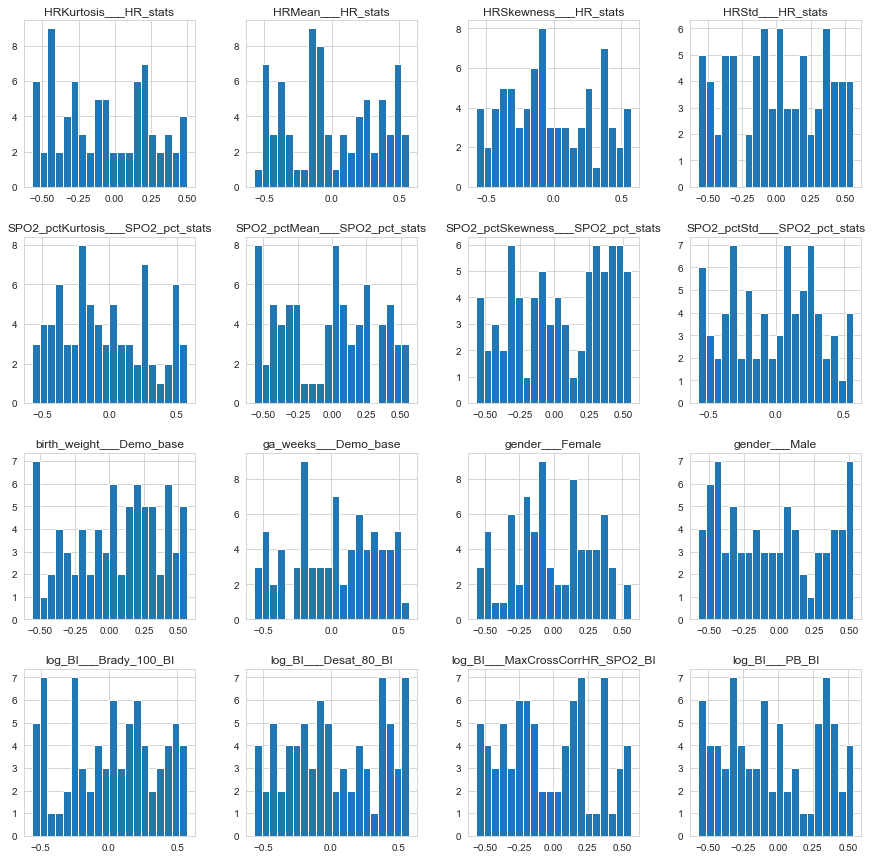

In [33]:
coef_df.hist(figsize=(15,15),bins=20);

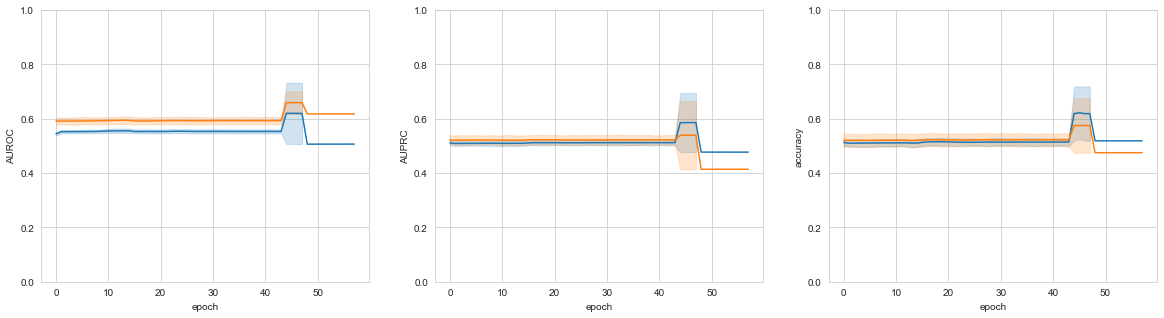

In [34]:
data = eval_df_trace_folds
data['AUROC'] = np.amax([data['AUROC'], 1-data['AUROC']],axis=0)
data['val_AUROC'] = np.amax([data['val_AUROC'], 1-data['val_AUROC']],axis=0)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs = axs.flatten()
sns.lineplot(x='epoch',y='AUROC', data=data, ax=axs[0])
sns.lineplot(x='epoch',y='val_AUROC', data=data, ax=axs[0])
axs[0].set_ylabel('AUROC')
axs[0].set_ylim(0,1)
sns.lineplot(x='epoch',y='AUPRC', data=data, ax=axs[1])
sns.lineplot(x='epoch',y='val_AUPRC', data=data, ax=axs[1])
axs[1].set_ylabel('AUPRC')
axs[1].set_ylim(0,1)
sns.lineplot(x='epoch',y='accuracy', data=data, ax=axs[2])
sns.lineplot(x='epoch',y='val_accuracy', data=data, ax=axs[2])
axs[2].set_ylabel('accuracy')
axs[2].set_ylim(0,1)
plt.show();

### RNN - LSTM
Use hourly inputs 7 days prior to the primary outcome, we build a single layer LSTM model which gives us optiimal evaluation results compare to other structures.

In [ ]:
# 2. define the episode
prvt_stream.engineer.DefineEpisode(input_time_len=7*24, output_time_len=1, time_resolution=1, time_lag=0, anchor_gap=None)
# 3. specify csv pool folder dir
csv_pool_path = '../project1_hourly/csv_pool'

# regression evaluation
eval_df_trace_folds = pd.DataFrame()
myMetrics = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.AUC(name='AUROC', curve='ROC'),
    keras.metrics.AUC(name='AUPRC', curve='PR'),
]

# all subjects
for i in range(10):
    
    train_df, valid_df, train_tfds, valid_tfds = prvt_stream.engineer.BuildMVTS(csv_pool_path, nsbj=200, train_frac=0.8, batch_size=32, impute_input='median', impute_output='median', return_data=True)
    
    eval_df_trace = pd.DataFrame()
    keras.backend.clear_session()

    # build the model
    input_shape = list(train_tfds.element_spec[0].shape)[1:3]
   # build the model
    lstm = keras.models.Sequential([
        keras.layers.LSTM(128, return_sequences=False, input_shape=input_shape),
        keras.layers.Dense(2, activation='softmax'),
        keras.layers.Reshape([1, -1])
    ])
    lstm.summary()

    # compile and run the model
    lstm.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=1e-4), metrics=myMetrics)
    callback = EarlyStopping(monitor='val_AUROC', patience=10);
    his =lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(lstm.optimizer.learning_rate, 1e-5)
    his = lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(lstm.optimizer.learning_rate, 1e-6)
    his = lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(lstm.optimizer.learning_rate, 1e-7)
    his = lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)

    eval_df_trace['epoch'] = eval_df_trace.reset_index(drop=True).index
    eval_df_trace['fold'] = i + 1

    eval_df_trace_folds = pd.concat([eval_df_trace_folds, eval_df_trace],sort=False)

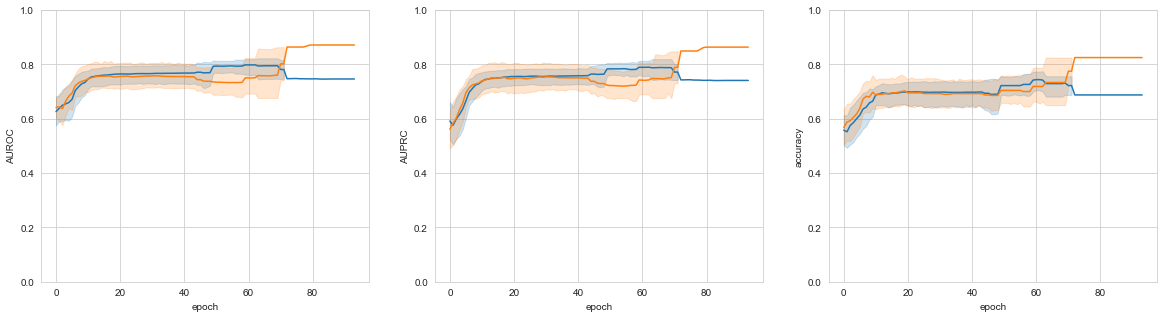

In [46]:
data = eval_df_trace_folds
data['AUROC'] = np.amax([data['AUROC'], 1-data['AUROC']],axis=0)
data['val_AUROC'] = np.amax([data['val_AUROC'], 1-data['val_AUROC']],axis=0)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs = axs.flatten()
sns.lineplot(x='epoch',y='AUROC', data=data, ax=axs[0])
sns.lineplot(x='epoch',y='val_AUROC', data=data, ax=axs[0])
axs[0].set_ylabel('AUROC')
axs[0].set_ylim(0,1)
sns.lineplot(x='epoch',y='AUPRC', data=data, ax=axs[1])
sns.lineplot(x='epoch',y='val_AUPRC', data=data, ax=axs[1])
axs[1].set_ylabel('AUPRC')
axs[1].set_ylim(0,1)
sns.lineplot(x='epoch',y='accuracy', data=data, ax=axs[2])
sns.lineplot(x='epoch',y='val_accuracy', data=data, ax=axs[2])
axs[2].set_ylabel('accuracy')
axs[2].set_ylim(0,1)
plt.show();

### RNN - deeper layers

Overfitting 

In [ ]:
# 2. define the episode
prvt_stream.engineer.DefineEpisode(input_time_len=7*24, output_time_len=1, time_resolution=1, time_lag=0, anchor_gap=None)
# 3. specify csv pool folder dir
csv_pool_path = '../project1_hourly/csv_pool'

# regression evaluation
eval_df_trace_folds = pd.DataFrame()
myMetrics = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.AUC(name='AUROC', curve='ROC'),
    keras.metrics.AUC(name='AUPRC', curve='PR'),
]

# all subjects
for i in range(10):
    
    train_df, valid_df, train_tfds, valid_tfds = prvt_stream.engineer.BuildMVTS(csv_pool_path, nsbj=200, train_frac=0.8, batch_size=32, impute_input='median', impute_output='median', return_data=True)
    
    eval_df_trace = pd.DataFrame()
    keras.backend.clear_session()

    # build the model
    input_shape = list(train_tfds.element_spec[0].shape)[1:3]
   # build the model
    lstm = keras.models.Sequential([
        keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32, return_sequences=False),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(2, activation='softmax'),
        keras.layers.Reshape([1, -1])
    ])
    lstm.summary()

    # compile and run the model
    lstm.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=1e-4), metrics=myMetrics)
    callback = EarlyStopping(monitor='val_AUROC', patience=10);
    his =lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(lstm.optimizer.learning_rate, 1e-5)
    his = lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(lstm.optimizer.learning_rate, 1e-6)
    his = lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(lstm.optimizer.learning_rate, 1e-7)
    his = lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)

    eval_df_trace['epoch'] = eval_df_trace.reset_index(drop=True).index
    eval_df_trace['fold'] = i + 1

    eval_df_trace_folds = pd.concat([eval_df_trace_folds, eval_df_trace],sort=False)

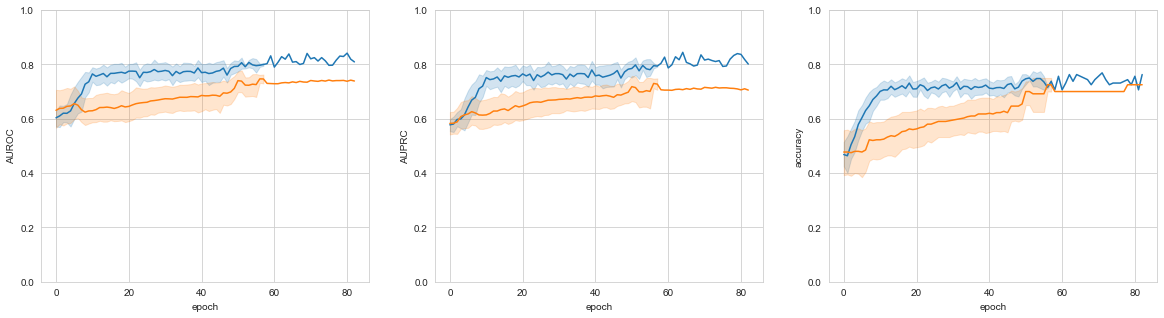

In [48]:
data = eval_df_trace_folds
data['AUROC'] = np.amax([data['AUROC'], 1-data['AUROC']],axis=0)
data['val_AUROC'] = np.amax([data['val_AUROC'], 1-data['val_AUROC']],axis=0)
data['AUPRC'] = np.amax([data['AUPRC'], 1-data['AUPRC']],axis=0)
data['val_AUPRC'] = np.amax([data['val_AUPRC'], 1-data['val_AUPRC']],axis=0)



fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs = axs.flatten()
sns.lineplot(x='epoch',y='AUROC', data=data, ax=axs[0])
sns.lineplot(x='epoch',y='val_AUROC', data=data, ax=axs[0])
axs[0].set_ylabel('AUROC')
axs[0].set_ylim(0,1)
sns.lineplot(x='epoch',y='AUPRC', data=data, ax=axs[1])
sns.lineplot(x='epoch',y='val_AUPRC', data=data, ax=axs[1])
axs[1].set_ylabel('AUPRC')
axs[1].set_ylim(0,1)
sns.lineplot(x='epoch',y='accuracy', data=data, ax=axs[2])
sns.lineplot(x='epoch',y='val_accuracy', data=data, ax=axs[2])
axs[2].set_ylabel('accuracy')
axs[2].set_ylim(0,1)
plt.show();

In [ ]:
# 2. define the episode
prvt_stream.engineer.DefineEpisode(input_time_len=7*24, output_time_len=1, time_resolution=1, time_lag=0, anchor_gap=None)
# 3. specify csv pool folder dir
csv_pool_path = '../project1_hourly/csv_pool'

# regression evaluation
eval_df_trace_folds = pd.DataFrame()
myMetrics = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.AUC(name='AUROC', curve='ROC'),
    keras.metrics.AUC(name='AUPRC', curve='PR'),
]

# all subjects
for i in range(10):
    
    train_df, valid_df, train_tfds, valid_tfds = prvt_stream.engineer.BuildMVTS(csv_pool_path, nsbj=200, train_frac=0.8, batch_size=32, impute_input='median', impute_output='median', return_data=True)
    
    eval_df_trace = pd.DataFrame()
    keras.backend.clear_session()

    # build the model
    input_shape = list(train_tfds.element_spec[0].shape)[1:3]
   # build the model
    lstm = keras.models.Sequential([
        keras.layers.LSTM(128, return_sequences=True, input_shape=input_shape),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(64, return_sequences=False),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(2, activation='softmax'),
        keras.layers.Reshape([1, -1])
    ])
    lstm.summary()

    # compile and run the model
    lstm.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=1e-4), metrics=myMetrics)
    callback = EarlyStopping(monitor='val_AUROC', patience=10);
    his =lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(lstm.optimizer.learning_rate, 1e-5)
    his = lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(lstm.optimizer.learning_rate, 1e-6)
    his = lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(lstm.optimizer.learning_rate, 1e-7)
    his = lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)

    eval_df_trace['epoch'] = eval_df_trace.reset_index(drop=True).index
    eval_df_trace['fold'] = i + 1

    eval_df_trace_folds = pd.concat([eval_df_trace_folds, eval_df_trace],sort=False)

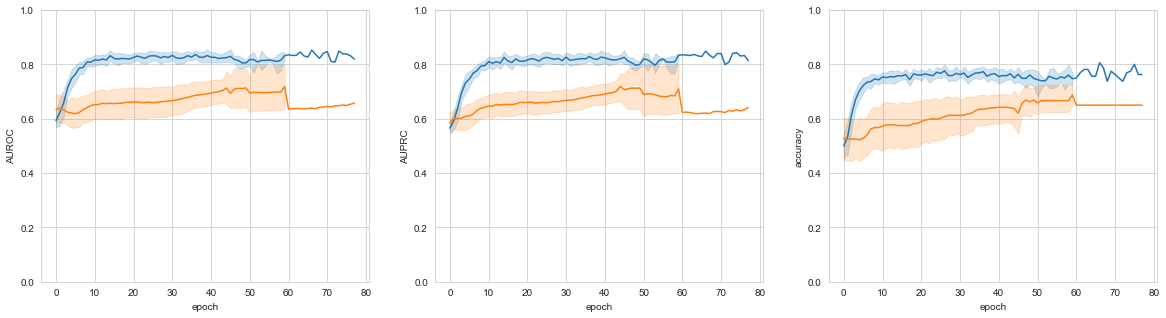

In [50]:
data = eval_df_trace_folds
data['AUROC'] = np.amax([data['AUROC'], 1-data['AUROC']],axis=0)
data['val_AUROC'] = np.amax([data['val_AUROC'], 1-data['val_AUROC']],axis=0)
data['AUPRC'] = np.amax([data['AUPRC'], 1-data['AUPRC']],axis=0)
data['val_AUPRC'] = np.amax([data['val_AUPRC'], 1-data['val_AUPRC']],axis=0)



fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs = axs.flatten()
sns.lineplot(x='epoch',y='AUROC', data=data, ax=axs[0])
sns.lineplot(x='epoch',y='val_AUROC', data=data, ax=axs[0])
axs[0].set_ylabel('AUROC')
axs[0].set_ylim(0,1)
sns.lineplot(x='epoch',y='AUPRC', data=data, ax=axs[1])
sns.lineplot(x='epoch',y='val_AUPRC', data=data, ax=axs[1])
axs[1].set_ylabel('AUPRC')
axs[1].set_ylim(0,1)
sns.lineplot(x='epoch',y='accuracy', data=data, ax=axs[2])
sns.lineplot(x='epoch',y='val_accuracy', data=data, ax=axs[2])
axs[2].set_ylabel('accuracy')
axs[2].set_ylim(0,1)
plt.show();